<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Vitaly-Krasikov-folder/Vitaly%20Krasikov/iris_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Постановка задачи

В данной работе предложено решение задачи идентификации человека по изображению радужной оболочки его глаза с использованием нейросетевых моделей. Задача формулируется следующим образом: дан датасет, состоящий из фотографий глаз пациентов клиники (от 3 до 8 фотографий каждого глаза), размеченный уникальными идентификаторами пациентов (числа от 1 до 89). Необходимо решить задачу классификации фотографий, где каждому классу взаимно однозначно соответствует пациент.

## Предварительная подготовка

In [ ]:
# Подключение модулей
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tensorflow.data import Dataset

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Сегментация картинок
import cv2



# Рисование графиков в ячейках Colab
%matplotlib inline

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/iris'       # Папка для обучающего набора данных
TEST_PATH           = '/content/iris_test'  # Папка для тестового набора данных
TRAIN_AUG_PATH      = '/content/iris_aug'   # Папка для аугментированного обучающего набора данных

TEST_SPLIT          = 0.2                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 192                   # Ширина изображения для нейросети
IMG_HEIGHT          = 144                   # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.8, 1.2)            # Пределы изменения яркости
HORIZONTAL_FLIP     = False                 # Горизонтальное отражение разрешено

EPOCHS              = 250                   # Число эпох обучения
BATCH_SIZE          = 8                     # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

## Сбор и подготовка данных

Датасет загружается с гугл-диска в виде архива, данные каждого пациента находятся в отдельной папке, имена папок совпадают с идентификаторами.

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab (64 класса)
# gdown.download('https://drive.google.com/uc?id=19ZzpBgbCDVdSgy9joK54wXt9-yURQGtM', None, quiet=True)

'iris.zip'

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab (89 классов)
gdown.download('https://drive.google.com/uc?id=1owRM4vWprid-FKgGoRg3BEPWWF-B-evq', None, quiet=True)

'iris89.zip'

In [ ]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "iris89.zip" -d {TRAIN_PATH}

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 89, метки классов: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089']


In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса 001: 6 фото, для теста выделено файлов: 1
Размер класса 002: 6 фото, для теста выделено файлов: 1
Размер класса 003: 6 фото, для теста выделено файлов: 1
Размер класса 004: 6 фото, для теста выделено файлов: 1
Размер класса 005: 6 фото, для теста выделено файлов: 1
Размер класса 006: 6 фото, для теста выделено файлов: 1
Размер класса 007: 6 фото, для теста выделено файлов: 1
Размер класса 008: 6 фото, для теста выделено файлов: 1
Размер класса 009: 6 фото, для теста выделено файлов: 1
Размер класса 010: 6 фото, для теста выделено файлов: 1
Размер класса 011: 6 фото, для теста выделено файлов: 1
Размер класса 012: 6 фото, для теста выделено файлов: 1
Размер класса 013: 6 фото, для теста выделено файлов: 1
Размер класса 014: 6 фото, для теста выделено файлов: 1
Размер класса 015: 6 фото, для теста выделено файлов: 1
Размер класса 016: 6 фото, для теста выделено файлов: 1
Размер класса 017: 6 фото, для теста выделено файлов: 1
Размер класса 018: 6 фото, для теста выделено фа

## Сегментация радужки

Уникальным признаком в данной задаче является рисунок радужки пациента, поэтому первая гипотеза заключается в том, что перед тем, как классифицировать изображения, сначала необходимо произвести их сегментацию, отделив изображение радужки. Для удобства это изображение в дальнейшем рассматривается в полярной системе координат (центр СК в центре изображения) и перед анализом приводится к декартовой СК (тем самым радужка из кольца разворачивается в прямоугольник).

Проблемой в этой формулировке остается приведение изображения к такому виду, чтобы центр картинки совпадал с центром зрачка (для чего необходимо найти центр зрачка). Кроме того, погрешности изображения возможны из-за того, что границы зрачка и радужки не являются в точности концентрическими окружностями, кроме того, строго говоря, не являются окружностями, а скорее, эллипсами с эксцентриситетом, близким к 0.

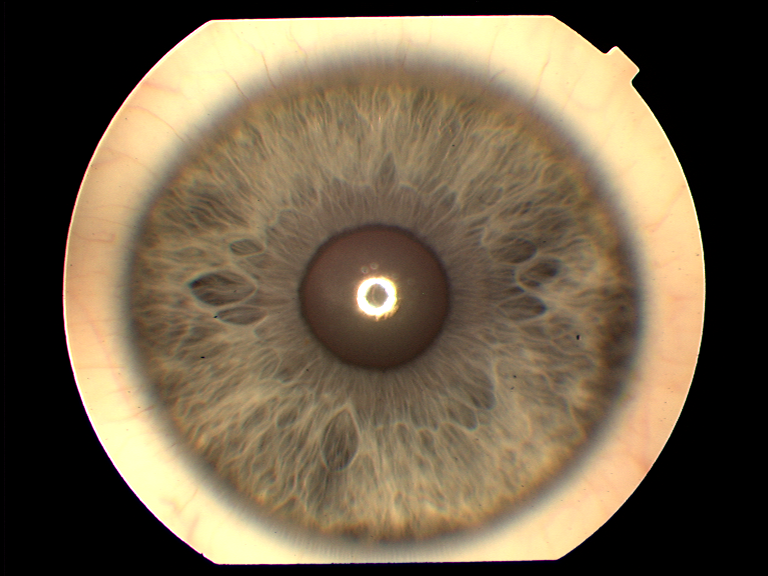

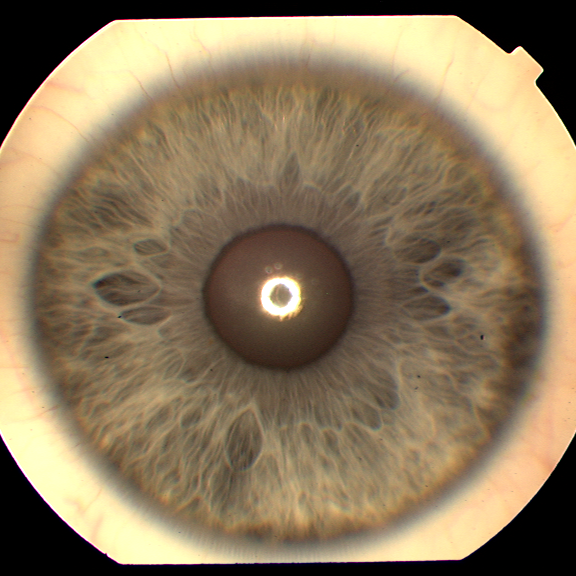

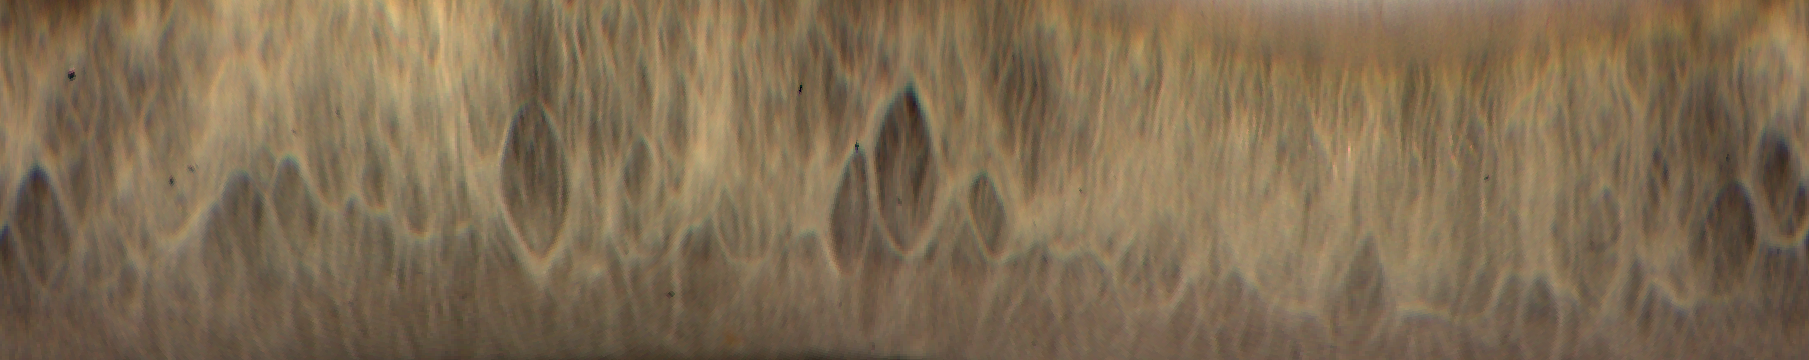

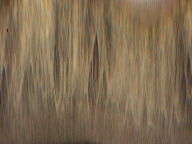

In [ ]:
import cv2
import math
from google.colab.patches import cv2_imshow


# взял функции у Андрея Шалунова и немного доработал

# обрезка изображения до квадрата
def unwrap_circular_image(image):

    # Берем центр изображения
    height, width = image.shape[:2]
    center_x, center_y = width // 2, height // 2

    # Вычисляем максимальный радиус окружности
    max_radius = min(center_x, center_y)

    return image[center_y - max_radius: center_y + max_radius, center_x - max_radius: center_x + max_radius]

# перевод из полярной системы координат в декартову
def ring_to_rect(image):

  size = image.shape[0]  # исходное изображение должно быть квадратным

  # здесь бы не помешало вычислить настоящие радиусы радужки и зрачка, но и так неплохо отделяет
  outer_radius = size // 2.5   # это радиус радужки
  inner_radius_factor = 0.375     # а это зрачка

  # Разворачиваем кольцо
  warped = cv2.warpPolar(image, (size, int(size * math.pi)), (size // 2, size // 2), outer_radius, 0)
  # Поворачиваем на 90 градусов
  straightened = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
  # Обрезаем
  cropped = straightened[: int(straightened.shape[0] * (1 - inner_radius_factor)), :]

  return cropped

# хочу использовать ImageDataGenerator и туда передавать свою функцию предобработки,
# но там есть странное требование, что входное и выходное изображение должны быть
# одного размера, короче, это костыль, потом надо будет переделать
# хотя, с другой стороны, что такое маленький resize по сравнению с тем,
# что с изображением нейронка потом делает
# функция изменения размера изображения
def resize(image):
  return cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)).astype('float64')

img = cv2.imread('./iris/010/010L_2.png')
unwrapped_image = unwrap_circular_image(img)
rect_image = ring_to_rect(unwrapped_image)
resized_image = resize(rect_image)

cv2_imshow(img)
cv2_imshow(unwrapped_image)
cv2_imshow(rect_image)
cv2_imshow(resized_image)

## Аугментация и формирование выборок

Для обучения нейронной сети используется аугментация набора данных с использованием класса ImageDataGenerator, добавляются небольшой поворот изображения и небольшое изменение яркости. Компьютерный эксперимент показал, что большое изменение яркости изображение приводит к ухудшению распознавания.

In [ ]:
# кастомная функция предобработки для генератора - после всех аугментаций
# разворачивает изображение в прямоугольное

def get_iris(image):
  return resize(ring_to_rect(unwrap_circular_image(image)))

In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    #width_shift_range=WIDTH_SHIFT_RANGE,
                    #height_shift_range=HEIGHT_SHIFT_RANGE,
                    #zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    #horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT,
                    preprocessing_function = get_iris
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.,
                   preprocessing_function = get_iris
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 531 images belonging to 89 classes.
Found 114 images belonging to 89 classes.
Found 139 images belonging to 89 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (8, 144, 192, 3), (8, 89), батчей: 67
Формы данных   проверочной выборки: (8, 144, 192, 3), (8, 89), батчей: 15
Формы данных      тестовой выборки: (139, 144, 192, 3), (139, 89), батчей: 1

Метки классов тренировочной выборки: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

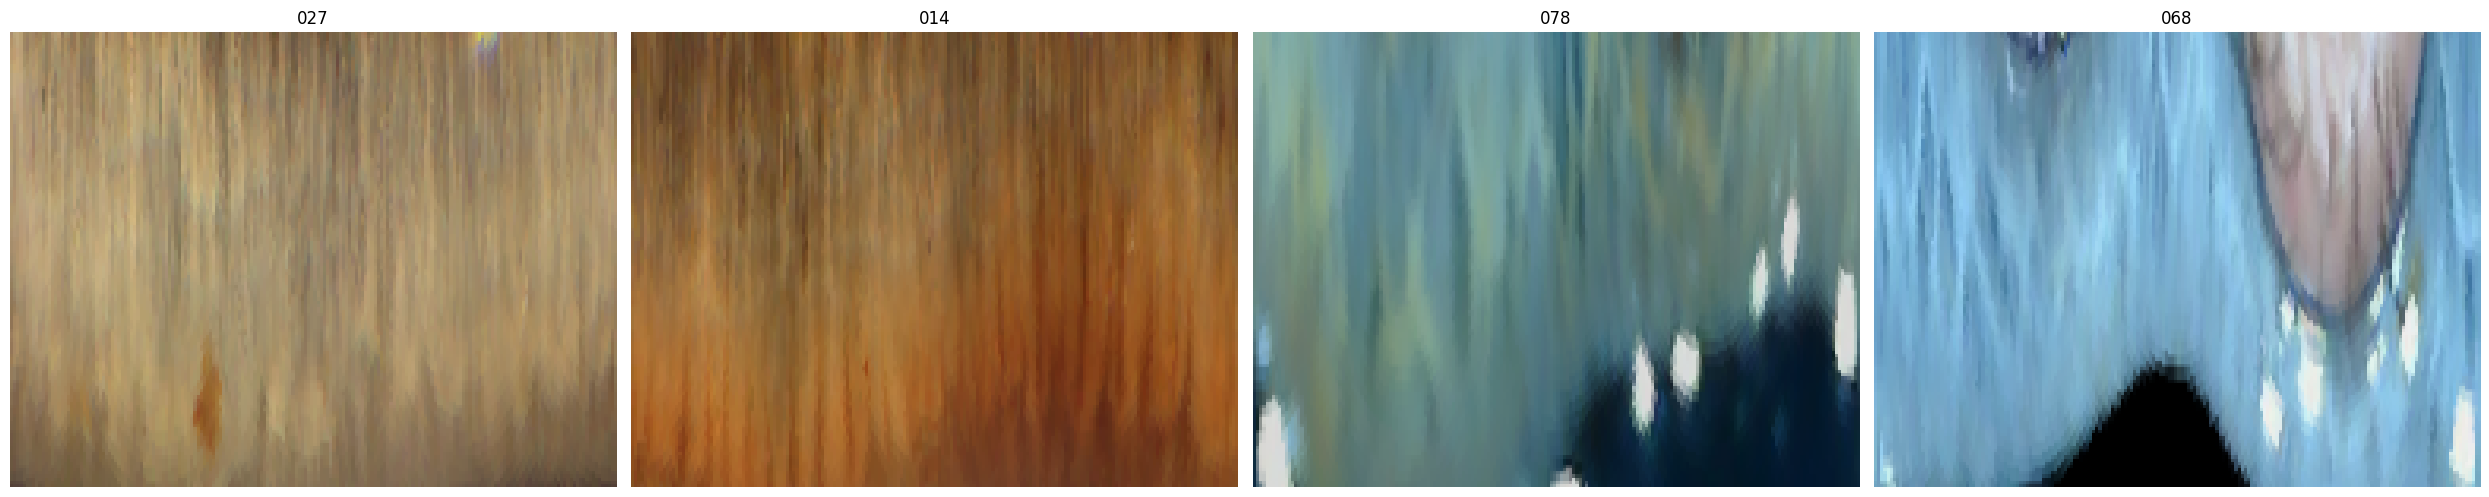

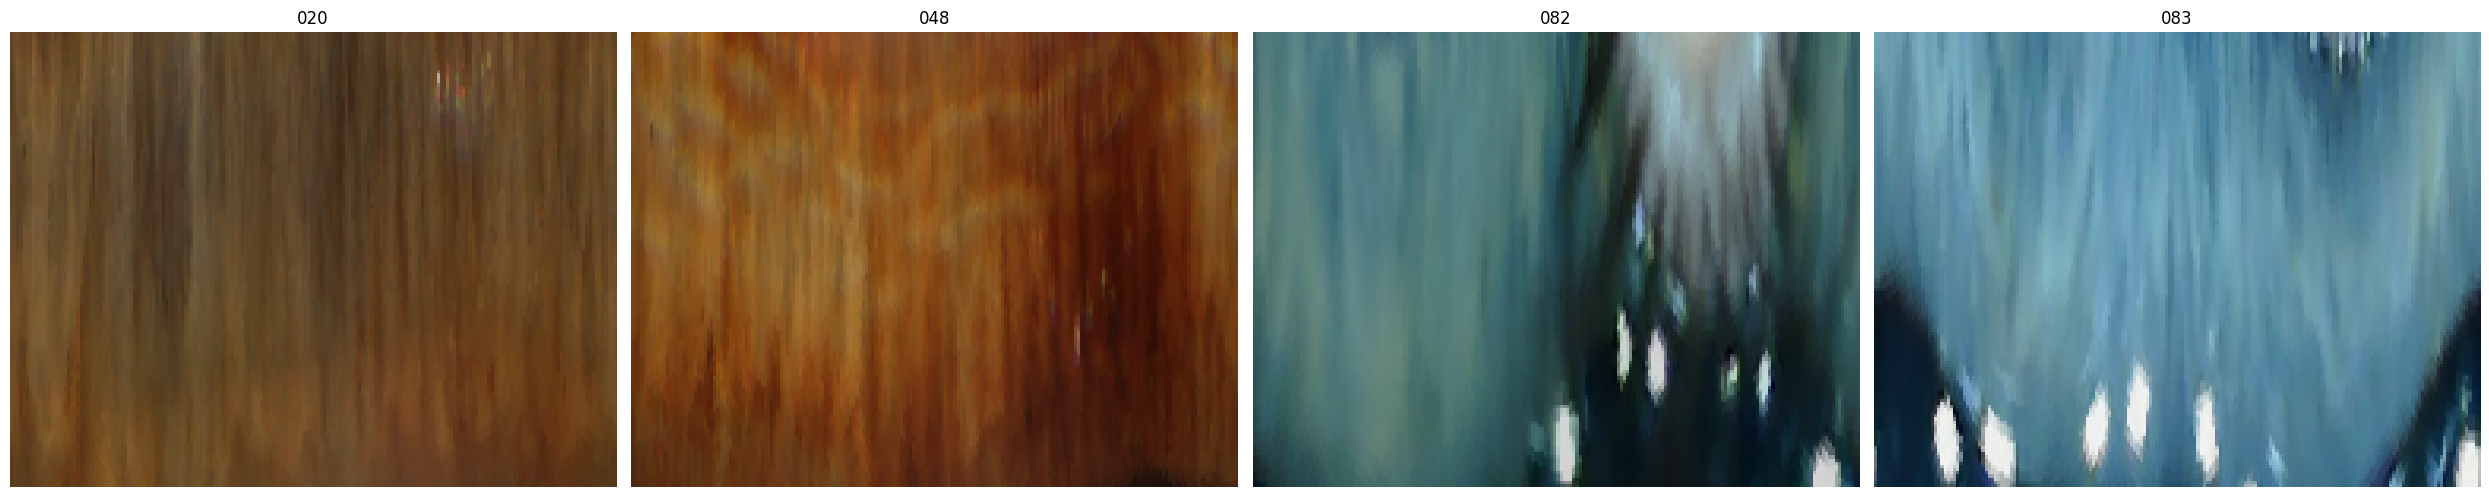

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0], range(8), columns = 4)

## Создание и обучение модели

Хорошие результаты показала следующая нейросетевая модель на сверточных слоях.

### Нейронка с занятий

In [ ]:
# Функция создания модели
def create_model(class_count=CLASS_COUNT):
  # Создание последовательной модели
  model_conv = Sequential()

  # Первый сверточный слой
  model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
  model_conv.add(BatchNormalization())

  # Второй сверточный слой
  model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model_conv.add(MaxPooling2D(pool_size=(3, 3)))

  # Третий сверточный слой
  model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model_conv.add(BatchNormalization())
  model_conv.add(Dropout(0.2))

  # Четвертый сверточный слой
  model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model_conv.add(MaxPooling2D(pool_size=(3, 3)))
  model_conv.add(Dropout(0.2))

  # Пятый сверточный слой
  model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model_conv.add(BatchNormalization())

  # Шестой сверточный слой
  model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
  model_conv.add(MaxPooling2D(pool_size=(3, 3)))
  model_conv.add(Dropout(0.2))

  # Слой преобразования многомерных данных в одномерные
  model_conv.add(Flatten())

  # Промежуточный полносвязный слой
  model_conv.add(Dense(2048, activation='relu'))

  # Промежуточный полносвязный слой
  model_conv.add(Dense(4096, activation='relu'))

  # Выходной полносвязный слой с количеством нейронов по количеству классов
  model_conv.add(Dense(class_count, activation='softmax'))

  return model_conv

In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### Тестирование моделей

In [ ]:
# model_conv = create_model()

In [ ]:
## Обучение модели и вывод оценки ее работы на тестовых данных
#compile_train_eval_model(model_conv,
#                         train_generator,
#                         validation_generator,
#                         test_generator,
#                         class_labels=CLASS_LIST,
#                         title='Сверточный классификатор')

In [ ]:
#model_conv.save_weights("iris_64_classes_weights.h5")

### Дообучение модели на большем количестве классов

Была разработана также функция, которая позволяет добавить в модель новые классы, сохранив при этом веса, отвечающие за старые (таким образом, для старых классов модель будет показывать хороший результат, дообучение понадобится только для новых).

In [ ]:
# Загрузка весов из облака
gdown.download('https://drive.google.com/uc?id=10PM27uhJrYQe6BVJEOCkapNHA_JA_7fY', None, quiet=True)

'iris_64_classes_weights.h5'

In [ ]:
# функция для расширения весов модели, загруженных из файла
# параметры - model_func - функция для создания модели,
# weights_file - имя файла с сохраненными весами,
# class_count - количество классов в файле,
# class_count_new - сколько должно быть классов в новой модели (должно быть больше или равно, чем class_count)
def extend_weights(model_func, weights_file, class_count=CLASS_COUNT, class_count_new=CLASS_COUNT):
  model = model_func(class_count)
  model.load_weights(weights_file)
  weights = model.get_weights()
  weights[-1] = np.concatenate((weights[-1],np.zeros(class_count_new-class_count)))
  # здесь будет ошибка, если форма предпоследнего слоя не одномерная (например, если будет двумерная свертка)
  weights[-2] = np.concatenate((weights[-2],np.zeros([weights[-2].shape[0],class_count_new-class_count])),axis=1)
  model_result = model_func(class_count_new)
  model_result.set_weights(weights)
  return model_result

Пример работы функции дообучения - взята модель, обученная на 64 классах, затем добавлены еще 25:

5/5 [==============================] - 17s 784ms/step


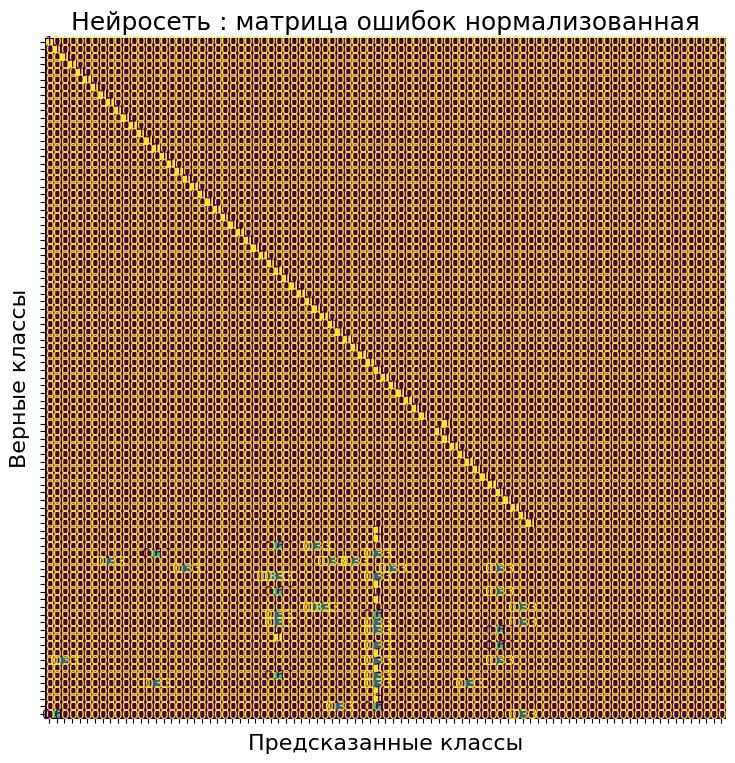

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  71%


In [ ]:
model_conv = extend_weights(create_model, "iris_64_classes_weights.h5", class_count=64)
eval_model(model_conv, test_generator[0][0], test_generator[0][1])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 144, 192, 256)     7168      
                                                                 
 batch_normalization_30 (Bat  (None, 144, 192, 256)    1024      
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 144, 192, 256)     590080    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 48, 64, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 48, 64, 256)       590080    
                                                                 
 batch_normalization_31 (Bat  (None, 48, 64, 256)    

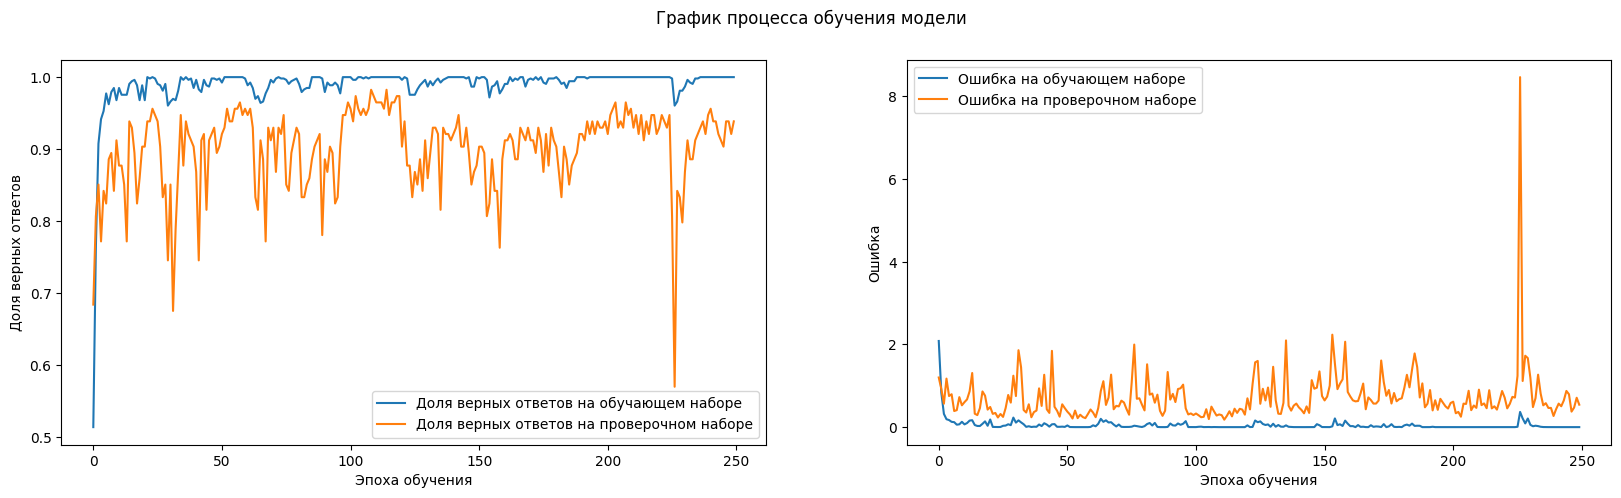

5/5 [==============================] - 1s 162ms/step


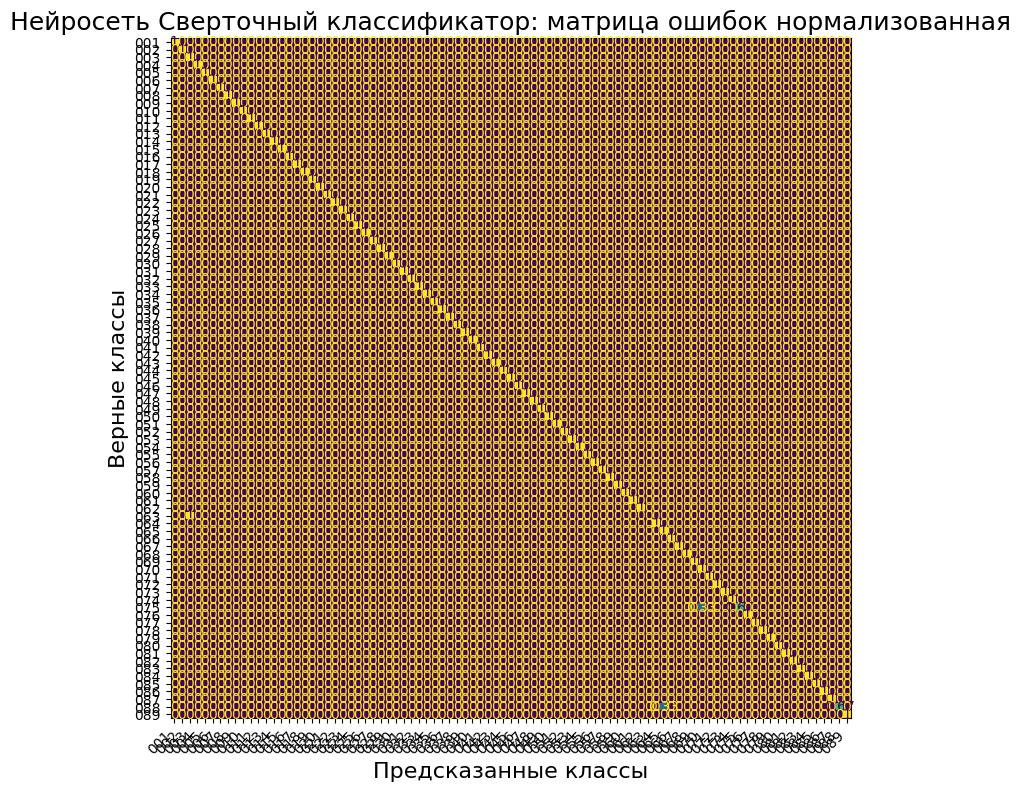

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: 001                  100% сеть отнесла к классу 001                  - ВЕРНО :-)
Класс: 002                  100% сеть отнесла к классу 002                  - ВЕРНО :-)
Класс: 003                  100% сеть отнесла к классу 003                  - ВЕРНО :-)
Класс: 004                  100% сеть отнесла к классу 004                  - ВЕРНО :-)
Класс: 005                  100% сеть отнесла к классу 005                  - ВЕРНО :-)
Класс: 006                  100% сеть отнесла к классу 006                  - ВЕРНО :-)
Класс: 007                  100% сеть отнесла к классу 007                  - ВЕРНО :-)
Класс: 008                  100% сеть отнесла к классу 008                  - ВЕРНО :-)
Класс: 009                  100% сеть отнесла к классу 009                  - ВЕРНО :-)
Класс: 010                  100% сеть отнесла к классу 010             

In [ ]:
# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                        train_generator,
                        validation_generator,
                        test_generator,
                        class_labels=CLASS_LIST,
                        title='Сверточный классификатор')

In [ ]:
model_conv.save_weights("iris_89_classes_weights.h5")

## Выводы

Модель, основанная на сверточных слоях, кажется потенциально подходящей для решения поставленной задачи, на 89 классах удалось добиться результата в accuracy 0.98 на тестовой выборке, тем не менее, стоит отметить, что такой результат может быть связан, в частности, с тем, что для каждого класса набор данных включает фотографии из одного сета, поэтому погрешности сегментации (например, присутствие части зрачка на фото), сами по себе могут быть признаками, по которым нейронная сеть отличает один класс от другого. Для того, чтобы исключить это, была проделана работа по улучшению качества сегментации, датасет размечен (на каждом изображении выделены радужка и зрачок) и эти данные использованы в функции, которая отделяет и разворачивает радужку (см. https://colab.research.google.com/drive/1XlnR9pcAlBBe0TVmJJIe1r2SPyW9Ipco?usp=sharing)

Качество обучения на таких данных действительно слегка падает, но логичным кажется использование именно их, поскольку там рисунок радужки играет существенно бОльшую роль.